In [1]:
import numpy as np
import random
import cPickle
import os.path
import math
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from keras.utils import *
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding, Input, Conv1D
from keras.layers.merge import Maximum, Concatenate, Average
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Lambda
from keras.constraints import maxnorm

from survey_reader import *
from w2v import train_word2vec
import data_helpers

currentpath = '/data1/shared_all/review_classification_Pengfei/'
os.chdir(currentpath)


Using TensorFlow backend.


# Load data and data preparation

In [2]:
def load_data(data_source, y):

    x, sequence_length, vocabulary, vocabulary_inv_list = data_helpers.load_data(data_source)
    print("x shape:", x.shape)
    print("y shape:", y.shape)
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}

    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x = x[shuffle_indices]
    y = y[shuffle_indices]

    train_len = int(len(x) * 0.8)
    x_train = x[:train_len]
    y_train = y[:train_len]
    x_test = x[train_len:]
    y_test = y[train_len:]

    embedding_file = './API/word2vec.p'
    if os.path.exists(embedding_file):
        embedding_weights = cPickle.load(open(embedding_file, "rb"))
    else:
        embedding_weights = data_helpers.load_bin_vec('/data1/shared_all/GoogleNews-vectors-negative300.bin', [new_vocab for new_vocab in vocabulary])
        cPickle.dump(embedding_weights, open(embedding_file, "wb"))

    x_train = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_train])
    x_test = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_test])

    return x_train, y_train, x_test, y_test, vocabulary_inv, sequence_length


xlsx_file = './data/HT Data.xlsx'
roi_list = ['HT Experience', 'Context', 'Content', 'Driver']
data, label = read_Surveycsv(xlsx_file, roi_list)

# Data Preparation
print("Load data...")
label_name = 'driver'
if label_name is 'context':
    class_name = label[0][1]
    nb_classes = len(label[0][1])
    sub_label = to_categorical(label[0][0], num_classes=nb_classes)
elif label_name is 'content':
    class_name = label[1][1]
    nb_classes = len(label[1][1])
    sub_label = to_categorical(label[1][0], num_classes=nb_classes)
else:
    class_name = label[2][1]
    nb_classes = len(label[2][1])
    sub_label = to_categorical(label[2][0], num_classes=nb_classes)
print(class_name)    
x_train, y_train, x_test, y_test, vocabulary_inv, sequence_length = load_data(data, sub_label)
print("sequence length:", sequence_length)

('uni_label', [u'Emergency', u'Ordinary Situation', u'Problem', u'Special Occasion'])
('uni_label', [u'Care from Staff', u'Dealer Event', u'Detailed Explanation', u'Forgotten Stuff', u'Free Service / Discount', u'Gift / Free Stuff', u'Gift / Free stuff', u'Issue Resolution', u'Others', u'Personal Need', u'Pick Up / Drop', u'Pick up / Drop', u'Quick Service', u'Roadside Assistance', u'Snacks'])
('uni_label', [u'Caring Attitude', u'Expertise', u'Flexibility', u'Others', u'Transparency'])
Load data...
Counter({u'Caring Attitude': 3008, u'Flexibility': 1383, u'Expertise': 1065, u'Transparency': 116, u'Others': 4})
('x shape:', (5576, 1033))
('y shape:', (5576, 5))
4549 out of 6261 words found in the word2vec vocab
('sequence length:', 1033)


# CNN model building

In [3]:
# Model Hyperparameters
embedding_dim = 300
vocabsize = len(vocabulary_inv)
dropout_prob = 0.3
batch_size = 50
num_epochs = 30
nb_filter = 100
filter_len = [3, 4, 5]
# hidden_dims = int(math.floor((len(filter_len) * nb_filter + nb_classes) / 3))
hidden_dims = 100


# Build CNN
print("Building CNN...")
graph_input1 = Input(shape=(sequence_length, embedding_dim))
embed1 = Embedding(vocabsize, embedding_dim, input_length=sequence_length, name="embedding")(graph_input1)
convs1 = []
for fsz in filter_len:
    conv1 = Conv1D(filters=nb_filter, kernel_size=fsz, activation='tanh', padding='same',)(graph_input1)
    pool1 = GlobalMaxPooling1D()(conv1)
    convs1.append(pool1)
# y1 = Concatenate()(convs1) if len(convs1) > 1 else convs1[0]
y1 = Concatenate()(convs1)
z1 = Dropout(dropout_prob)(y1)

z1 = Dense(hidden_dims, kernel_constraint=maxnorm(2))(z1)
print("hidden dim:", hidden_dims)
# z1 = BatchNormalization()(z1)
z1 = Activation('tanh')(z1)
z1 = Dropout(dropout_prob)(z1)

z1 = Dense(nb_classes)(z1)
# z1 = BatchNormalization()(z1)
model_output1 = Activation('softmax')(z1)
cnn_model = Model(inputs=graph_input1, outputs=model_output1)
cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Building CNN...
('hidden dim:', 100)


# Model Training

In [4]:
# Train CNN
print("Training CNN...")
acc_list = []
for i in range(1, num_epochs + 1):
    print("\nTraining for epoch %d / %d" % (i, num_epochs))
    cnn_model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=2)
    loss1, accuracy1 = cnn_model.evaluate(x_test, y_test, verbose=2)
    acc_list.append(accuracy1*100)
    print('%s result is : %0.2f' % (label_name, accuracy1 * 100))



Training CNN...

Training for epoch 1 / 30
Epoch 1/1
11s - loss: 1.0789 - acc: 0.5209
driver result is : 59.05

Training for epoch 2 / 30
Epoch 1/1
10s - loss: 0.9511 - acc: 0.5809
driver result is : 59.32

Training for epoch 3 / 30
Epoch 1/1
10s - loss: 0.8591 - acc: 0.6330
driver result is : 60.30

Training for epoch 4 / 30
Epoch 1/1
10s - loss: 0.7601 - acc: 0.6899
driver result is : 60.30

Training for epoch 5 / 30
Epoch 1/1
9s - loss: 0.6604 - acc: 0.7399
driver result is : 62.01

Training for epoch 6 / 30
Epoch 1/1
9s - loss: 0.5785 - acc: 0.7749
driver result is : 60.48

Training for epoch 7 / 30
Epoch 1/1
9s - loss: 0.4256 - acc: 0.8428
driver result is : 57.62

Training for epoch 8 / 30
Epoch 1/1
9s - loss: 0.3283 - acc: 0.8854
driver result is : 59.32

Training for epoch 9 / 30
Epoch 1/1
10s - loss: 0.2474 - acc: 0.9202
driver result is : 58.24

Training for epoch 10 / 30
Epoch 1/1
10s - loss: 0.1914 - acc: 0.9381
driver result is : 60.75

Training for epoch 11 / 30
Epoch 1/1

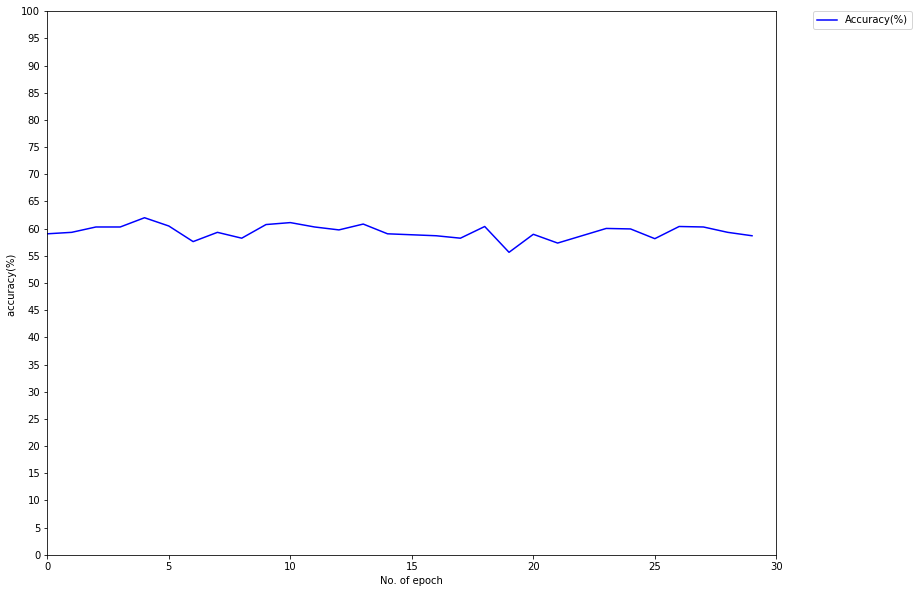

In [5]:
# plot accuracy  for every epoch
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(15, 10))
ax = fig.add_subplot(111)
ax.plot(range(num_epochs), acc_list, 'b', label='Accuracy(%)')
plt.axis([0, num_epochs, 0, 100])

plt.xticks(np.arange(0, num_epochs + 1, 5.0))
plt.yticks(np.arange(0, 101, 5.0))
plt.ylabel('accuracy(%) ')
plt.xlabel('No. of epoch')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.subplots_adjust(right=0.8)
plt.show()

In [3]:
s = 'aa bb  cc'
sentences = s.split(" ")
sentences

['aa', 'bb', '', 'cc']